In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses
import zipfile
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow_addons as tfa

In [ ]:
import os
import glob

In [ ]:
zipped_images = "/content/drive/MyDrive/Colab Notebooks/BreastCancer/final_train_images.zip"
unzip_output = "/content/sample_data/BreastCancer/"

In [ ]:
with zipfile.ZipFile(zipped_images, 'r') as z:
  z.extractall(unzip_output)

In [ ]:
img_folder = unzip_output + "SDLjpg1024/"

In [ ]:
len(list(glob.glob(img_folder + "**/*")))

54706

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BreastCancer/train.csv")
df = df[df['difficult_negative_case']==False]
df = df[~(df['density']=='D')].sample(frac=1)

In [ ]:
df.shape

(45727, 14)

In [ ]:
df['file_path'] = df.apply(lambda r : os.path.join(img_folder, str(r['patient_id']), str(r['image_id']) + '.jpg'), axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['cancer'])

In [ ]:
img_size=1024
def get_img_arr(file_path):
    img = tf.io.read_file(file_path)
    img_arr = tf.image.decode_jpeg(img, channels=1)
    # img_arr = tf.image.resize_with_crop_or_pad(img_arr, img_size, img_size)
    img_arr = tf.image.resize(img_arr, (img_size, img_size))
    img_arr = tf.cast(img_arr, tf.float32)
    return img_arr



In [ ]:
for p in train_df['file_path']:
    img_arr = get_img_arr(p)
    print(img_arr.get_shape())
    break

(1024, 1024, 1)


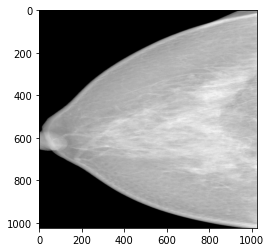

In [ ]:
plt.imshow(img_arr.numpy()[:,:,0], cmap='gray')
plt.show()

In [ ]:
train_positive = train_df[train_df['cancer']==1]
train_negative = train_df[train_df['cancer']==0]

In [ ]:
train_positive.shape, train_negative.shape

((963, 15), (37904, 15))

In [ ]:
def over_sampling(fold):
  new_df = pd.concat([train_positive] * fold + [train_negative], axis=0, ignore_index=True)
  new_df = new_df.sample(frac=1).reset_index(drop=True)
  return new_df

In [ ]:
oversample_train_df = over_sampling(15)

In [ ]:
oversample_train_df.shape

(52349, 15)

In [ ]:
batch_size=16
train_ds = tf.data.Dataset.from_tensor_slices((
    oversample_train_df['file_path'].to_numpy(),
    oversample_train_df['cancer'].to_numpy().astype('int16')
    )).shuffle(1000)
val_ds = tf.data.Dataset.from_tensor_slices((
    val_df['file_path'].to_numpy(), 
    val_df['cancer'].to_numpy().astype('int16')
    ))

def path_to_image(file_path, label):
  return get_img_arr(file_path), label

train_ds = train_ds.map(path_to_image).batch(batch_size).prefetch(batch_size)
val_ds = val_ds.map(path_to_image).batch(batch_size).prefetch(batch_size)



In [ ]:
# batch_size = 32
# train_pos_ds = tf.data.Dataset.from_tensor_slices((train_positive['file_path'].to_numpy(), train_positive['cancer'].to_numpy().astype('int16')))
# train_neg_ds = tf.data.Dataset.from_tensor_slices((train_negative['file_path'].to_numpy(), train_negative['cancer'].to_numpy().astype('int16')))
# val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_path'].to_numpy(), val_df['cancer'].to_numpy().astype('int16')))
# train_pos_ds = train_pos_ds.shuffle(500)
# train_neg_ds = train_neg_ds.shuffle(500)
# train_ds = tf.data.Dataset.sample_from_datasets([train_pos_ds, train_neg_ds], weights=[0.4, 0.6], stop_on_empty_dataset=True)

# n_train_samples = len(list(train_ds))
# n_val_samples = len(list(val_ds))
# train_steps = n_train_samples // batch_size - 5
# val_steps = n_val_samples // batch_size - 5

# path_to_image = lambda file_path, label: (get_img_arr(file_path), label)
# train_ds = train_ds.map(path_to_image)
# val_ds = val_ds.map(path_to_image)

# # for img, label in train_ds.take(10):
# #     print(img.shape)
# #     print(label)

# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(batch_size)
# val_ds = val_ds.batch(batch_size, drop_remainder=True).prefetch(batch_size)

In [ ]:
# n_train_samples, n_val_samples, train_steps, val_steps

In [ ]:
# train_size = len(list(train_ds))
# val_size = len(list(val_ds))
# print("train size: ", train_size)
# print("validation size: ", val_size)

In [ ]:
img_augmentation = tf.keras.models.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomFlip(),
    layers.RandomZoom(0.1)
],
name='img_augmentation')

In [ ]:
def lr_schedule(epoch):
  if epoch < 2:
    return 3e-4
  elif epoch < 6:
    return 1e-4
  else:
    return 5e-5

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
def build_model():
  pretrained_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
  pretrained_model.trainable = True
  
#     # Fine-tune from this layer onwards
#     fine_tune_at = 50

#     # Freeze all the layers before the `fine_tune_at` layer
#     for layer in pretrained_model.layers[:fine_tune_at]:
#         layer.trainable = False

  inputs = layers.Input(shape=(img_size, img_size, 1))
  x = img_augmentation(inputs)
  x = layers.concatenate([x, x, x])
  x = pretrained_model(x)
  x = layers.GlobalAveragePooling2D()(x)
  # x = layers.Flatten()(x)
  # x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.4)(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)
  
  thresholds = 0.5
  model.compile(
      loss='binary_crossentropy',
      optimizer=optimizers.Adam(learning_rate=1e-3),
      metrics=[tf.keras.metrics.Recall(thresholds=thresholds), 
                tf.keras.metrics.Precision(thresholds=thresholds), 
                tfa.metrics.F1Score(num_classes=1, threshold=thresholds, name='F1'),
              #  pFBeta(beta=1, name='pF1')
                ]
  )
  
  return model

In [ ]:
def build_cnn():
  inputs = layers.Input(shape=(img_size,img_size,1))
  x = img_augmentation(inputs)
  x = layers.Rescaling(1./255)(x)
  x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
  x = layers.AveragePooling2D()(x)
  x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
  x = layers.AveragePooling2D()(x)
  x = layers.Conv2D(32, 5, padding='same', activation='relu')(x)
  x = layers.AveragePooling2D()(x)
  x = layers.Conv2D(64, 5, padding='same', activation='relu')(x)
  x = layers.AveragePooling2D()(x)
  x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
  x = layers.AveragePooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.models.Model(inputs, x)

  thresholds = 0.5
  model.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(),
        metrics=[tf.keras.metrics.Recall(thresholds=thresholds), 
                 tf.keras.metrics.Precision(thresholds=thresholds), 
                 tfa.metrics.F1Score(num_classes=1, threshold=thresholds, name='F1'),
                #  pFBeta(beta=1, name='pF1')
                 ]
    )
    
  return model

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

# Then build your model within the strategy context:
tf.keras.backend.clear_session()
with strategy.scope():
    model = build_model()
    
model.summary()

Not connected to a TPU runtime. Using CPU/GPU strategy


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 img_augmentation (Sequential)  (None, 1024, 1024,   0           ['input_2[0][0]']                
                                1)                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 1024, 1024,   0           ['img_augmentation[0][0]',       
                                3)                                'img_augmentation[0][0]',   

In [ ]:
cp_dir = "/content/drive/MyDrive/Colab Notebooks/BreastCancer/checkpoints5"
if not os.path.exists(cp_dir):
  os.mkdir(cp_dir)
checkpoint_path = cp_dir + "/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
r = model.fit(
    train_ds,
    epochs=10,
    # steps_per_epoch = train_steps,
    # validation_steps = val_steps,
    validation_data = val_ds,
    callbacks=[callback, cp_callback]
)

Epoch 1/10


3272/3272 [==============================] - ETA: 0s - loss: 0.4833 - recall: 0.3612 - precision: 0.6727 - F1: 0.4700
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/BreastCancer/checkpoints5/cp-0001.ckpt
3272/3272 [==============================] - 2175s 650ms/step - loss: 0.4833 - recall: 0.3612 - precision: 0.6727 - F1: 0.4700 - val_loss: 0.2917 - val_recall: 0.5588 - val_precision: 0.1058 - val_F1: 0.1779 - lr: 3.0000e-04
Epoch 2/10
3272/3272 [==============================] - ETA: 0s - loss: 0.3145 - recall: 0.6829 - precision: 0.7912 - F1: 0.7331
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/BreastCancer/checkpoints5/cp-0002.ckpt
3272/3272 [==============================] - 2117s 647ms/step - loss: 0.3145 - recall: 0.6829 - precision: 0.7912 - F1: 0.7331 - val_loss: 0.2297 - val_recall: 0.5059 - val_precision: 0.1333 - val_F1: 0.2110 - lr: 3.0000e-04
Epoch 3/10
3272/3272 [==============================] - ETA: 0s - loss: 0.1461 - recall: 0.8872 -

In [ ]:
for i in range(1,11):
  model.load_weights(cp_dir + "/cp-{:04d}.ckpt".format(i))
  model.save_weights("/content/drive/MyDrive/Colab Notebooks/BreastCancer/SavedWeights_ep{:04d}.h5".format(i))

In [ ]:
# model.load_weights(cp_dir + "/cp-0005.ckpt")

In [ ]:
model.evaluate(val_ds)

429/429 [==============================] - 48s 111ms/step - loss: 0.2243 - recall: 0.2059 - precision: 0.3241 - F1: 0.2518


[0.22434188425540924,
 0.20588235557079315,
 0.32407405972480774,
 array([0.25179857], dtype=float32)]

In [ ]:
# model.save_weights("/content/drive/MyDrive/Colab Notebooks/BreastCancer/weights_v3.h5")
# model.save("/content/drive/MyDrive/Colab Notebooks/BreastCancer/efficientnetb0_trained0.2817.h5")

In [ ]:
from google.colab import runtime
runtime.unassign()